In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
import seaborn as sns

for i in range(2):
    matplotlib.rc('font', size=15)

task_names = ['Length', 'WordContent', 'Depth', 'TopConstituents', 'BigramShift', 'Tense', 'SubjNumber', 
              'ObjNumber', 'OddManOut', 'CoordinationInversion']
glue_tasks = ["CoLA", "SST-2", "Sara"]
baselines = {"majority": [20.0, 0.5, 17.9, 5.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0],
             "human": [100, 100, 84.0, 84.0, 98.0, 85.0, 88.0, 86.5, 81.2, 85.0],
             "conneau-best": [99.3, 88.8, 63.8, 89.6, 83.6, 91.5, 95.1, 95.1, 73.6, 76.2]}

def get_task_type(task):
    if task in ['Length', 'WordContent']: return "surface"
    if task in ['Depth', 'TopConstituents', 'BigramShift']: return "syntactic"
    return "semantic"
task_type_codes = {"surface": 0, "syntactic": 1, "semantic": 2}
task_type_colours = [np.array(colors.to_rgb(c)) for c in ["seagreen", "teal", "steelblue"]]
glue_task_colours = {}

def colour_to_bw(cl):
    if len(cl) == 3: return np.array([np.mean(cl), np.mean(cl), np.mean(cl)]) # rgb
    return np.array([np.mean(cl[:3]), np.mean(cl[:3]), np.mean(cl[:3]), cl[3]]) #rgba
def modify_cl(cl, modifier):
    cl = cl*modifier
    return np.array([max(0, min(c, 1.0)) for c in cl])

T = len(task_names)
strategies = ["single", "max", "avg"]
files = {
    "teacher_CoLA_L-1": {strategy: "teacher_CoLA_{}_-1.csv".format(strategy) for strategy in strategies},
    "teacher_CoLA_L11": {strategy: "teacher_CoLA_{}_11.csv".format(strategy) for strategy in strategies},
    "teacher_CoLA_L0": {strategy: "teacher_CoLA_{}_0.csv".format(strategy) for strategy in strategies},
    "teacher_SST-2_L-1": {strategy: "teacher_SST-2_{}_-1.csv".format(strategy) for strategy in strategies},
    "teacher_Sara_L-1": {strategy: "teacher_Sara_{}_-1.csv".format(strategy) for strategy in strategies},
}

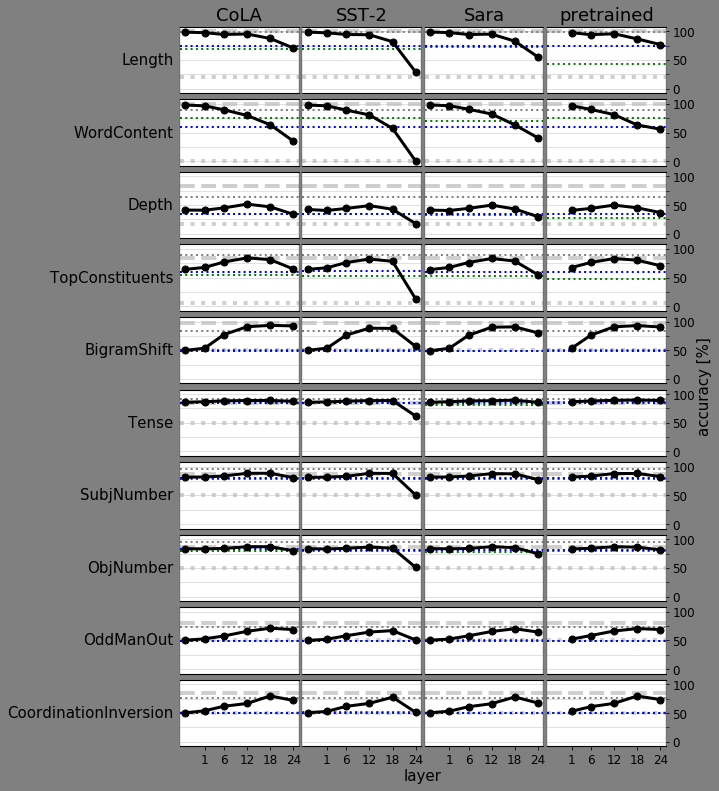

In [10]:
layers = {"CoLA": ["E", 0, 5, 11, 17, -1],
          "SST-2": ["E", 0, 5, 11, 17, -1],
          "Sara": ["E", 0, 5, 11, 17, -1],
          "pretrained": [0, 5, 11, 17, -1],}
layers_to_plot_all = {"CoLA": np.array([-5, 0, 5, 11, 17, 23]),
                  "SST-2": np.array([-5, 0, 5, 11, 17, 23]),
                  "Sara": np.array([-5, 0, 5, 11, 17, 23]),
                  "pretrained": np.array([0, 5, 11, 17, 23]),}
embed_types = ["word", "wordpiece"]
ncols = 4
fig, axs = plt.subplots(nrows=T, ncols=ncols, figsize=(10, 11), sharex=True, sharey=True)

vals_to_plot = {}
vals_to_plot_embed = {}
for col, glue_task in enumerate(glue_tasks + ["pretrained"]):
    group = "teacher_{}_avg".format(glue_task)
    vals_to_plot[glue_task] = {}
    for layer in layers[glue_task]:
        data = pd.read_csv("probing/{}_{}.csv".format(group, layer))
        vals_to_plot[glue_task][layer] = {}
        for task_name in task_names:
            rows = data[data["task"] == task_name]
            best_row = rows.loc[rows["devacc"].idxmax()]
            vals_to_plot[glue_task][layer][task_name] = best_row["acc"]
    vals_to_plot_embed[glue_task] = {}
    for embed_type in embed_types:
        data = pd.read_csv("probing/embed_{}_{}_avg.csv".format(embed_type, glue_task))
        vals_to_plot_embed[glue_task][embed_type] = {}
        for task_name in task_names:
            rows = data[data["task"] == task_name]
            best_row = rows.loc[rows["devacc"].idxmax()]
            vals_to_plot_embed[glue_task][embed_type][task_name] = best_row["acc"]
        data = pd.read_csv("probing/embed_{}_{}_avg-old.csv".format(embed_type, glue_task))
        vals_to_plot_embed[glue_task][embed_type + "-old"] = {}
        for task_name in task_names:
            rows = data[data["task"] == task_name]
            best_row = rows.loc[rows["devacc"].idxmax()]
            vals_to_plot_embed[glue_task][embed_type + "-old"][task_name] = best_row["acc"]
            
yticks_major = np.arange(3)*50
yticks_minor = np.arange(5)*25
yticklabels = np.arange(3)*50
grid_colour = np.array([1.0, 1.0, 1.0, 1.0])*0.85
for row, task_name in enumerate(task_names):
    axs[row][0].set_ylabel(task_name, rotation=0, labelpad=3, horizontalalignment="right", verticalalignment="center")
    for col, glue_task in enumerate(glue_tasks + ["pretrained"]):
        layers_to_plot = layers_to_plot_all[glue_task]
        axs[0][col].set_title(glue_task)
        ax = axs[row][col]
        c_grey, lw = np.array([1.0, 1.0, 1.0, 1.0])*0.75, 4
        ax.axhline(baselines["majority"][row], linestyle=":", c=c_grey, lw=lw)
        ax.axhline(baselines["human"][row], linestyle="--", c=c_grey, lw=lw)
        ax.axhline(baselines["conneau-best"][row], linestyle=":", c="grey", lw=2)
        ax.axhline(vals_to_plot_embed[glue_task]["word"][task_name], linestyle=":", c="green", lw=2)
        ax.axhline(vals_to_plot_embed[glue_task]["wordpiece"][task_name], linestyle=":", c="blue", lw=2)
        
        ax.tick_params(axis="y", which="both", length=0)
        
        if row < T-1:
            ax.tick_params(axis="x", which="both", length=0)
        else:
            ax.set_xticks(layers_to_plot)
            ax.tick_params("x", labelsize=12)
            xticklabels = ["E" if l == -4 else str(l) for l in (layers_to_plot+1)]
            ax.set_xticklabels(xticklabels)

        if col == ncols - 1:
            ax.tick_params("y", right=True, left=False, labelright=True, length=3, which="both", labelsize=12)
            ax.set_yticks(yticks_major, minor=False)
            ax.set_yticks(yticks_minor, minor=True)
            ax.set_yticklabels(yticklabels)
        else:
            ax.tick_params("y", left=False, labelleft=False, right=False, labelright=False)

        vals = [vals_to_plot[glue_task][l][task_name] for l in layers[glue_task]]
        ax.plot(layers_to_plot, vals, lw=3, markersize=7, marker="o", color="black")
        ax.set_ylim(bottom=-8, top=108)
        ax.grid(axis="y", color=grid_colour, which="both")
        [i.set_linewidth(1.1) for i in [ax.spines[k] for k in ["top", "bottom"]]]
        [i.set_linewidth(0.2) for i in [ax.spines[k] for k in ["right", "left"]]]

fig.tight_layout(h_pad=0.0, w_pad=0.1)

fig.add_subplot(111, frameon=False)
ax = plt.gca()
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, length=0)
ax.set_xlabel("layer")
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel("accuracy [%]")

fig.patch.set_facecolor("grey")
# ax.set_facecolor("grey")

plt.show()
fig.savefig("img/probing_master.png")

In [46]:
def despine(a):
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["bottom"].set_visible(False)
    a.spines["left"].set_visible(False)

In [30]:
layers = {"CoLA": {"BERT": ["E", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], "LSTM": [-1]},
          "SST-2": {"BERT": ["E", 0, 1, 2, 3, 4], "LSTM": [-1]},
          "Sara": {"BERT": ["E", 0, 1, 2, 3, 4], "LSTM": [-1]}}
glue_to_embed_type = {"CoLA": "word", "SST-2": "word", "Sara": "wordpiece"}
embed_types = ["word", "wordpiece"]

vals_to_plot = {}
vals_to_plot_embed = {}
for col, glue_task in enumerate(glue_tasks):
    vals_to_plot[glue_task] = {}
    for model_type in ["BERT", "LSTM"]:      
        group = "student_{}_{}_avg".format(glue_task, model_type)
        vals_to_plot[glue_task][model_type] = {}
        for layer in layers[glue_task][model_type]:
            data = pd.read_csv("probing/{}_{}.csv".format(group, layer))
            vals_to_plot[glue_task][model_type][layer] = {}
            for task_name in task_names:
                rows = data[data["task"] == task_name]
                best_row = rows.loc[rows["devacc"].idxmax()]
                vals_to_plot[glue_task][model_type][layer][task_name] = best_row["acc"]
    vals_to_plot_embed[glue_task] = {}
    for embed_type in embed_types:
        data = pd.read_csv("probing/embed_{}_{}_avg.csv".format(embed_type, glue_task))
        vals_to_plot_embed[glue_task][embed_type] = {}
        for task_name in task_names:
            rows = data[data["task"] == task_name]
            best_row = rows.loc[rows["devacc"].idxmax()]
            vals_to_plot_embed[glue_task][embed_type][task_name] = best_row["acc"]

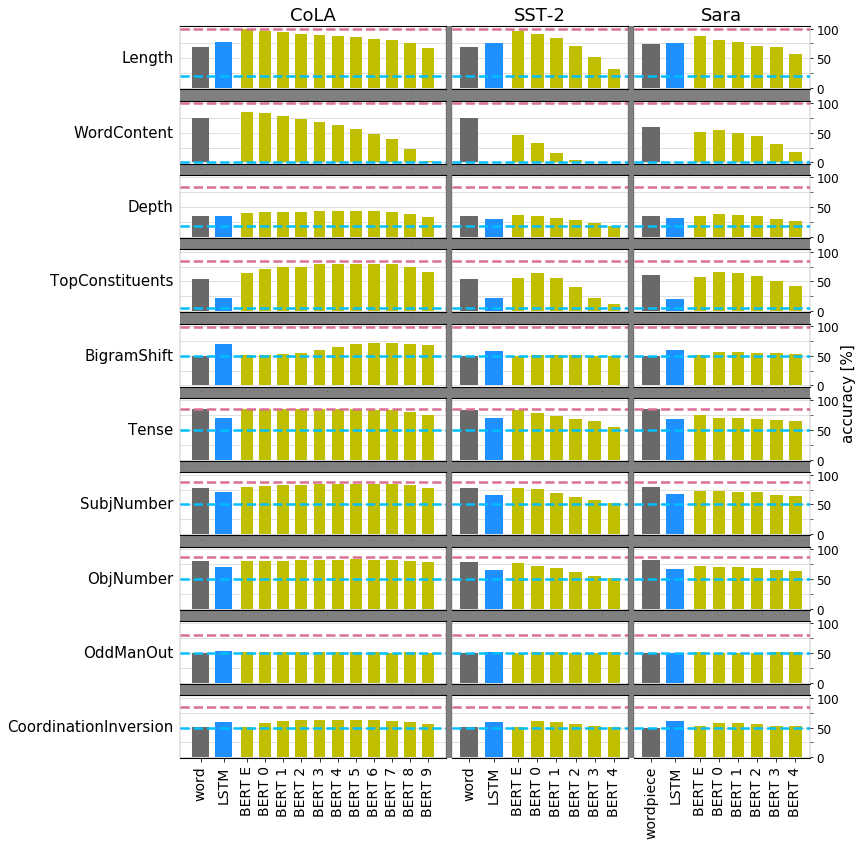

In [50]:
ncols = 3
fig, axs = plt.subplots(nrows=T, ncols=ncols, figsize=(12, 12), sharex=True, sharey=True)
yticks_major = np.arange(3)*50
yticks_minor = np.arange(5)*25
grid_colour = np.array([1.0, 1.0, 1.0, 1.0])*0.85
for row, task_name in enumerate(task_names):
    for col, glue_task in enumerate(glue_tasks):
        ax = plt.subplot2grid((T, 7), (row, [0, 3, 5][col]), colspan=[3, 2, 2][col], zorder=2)
        if col == 0:
            ax.set_ylabel(task_name, rotation=0, labelpad=3, horizontalalignment="right", verticalalignment="center")
        if row == 0:
            ax.set_title(glue_task)
        
        # embed, LSTM, BERT
        w = 0.8
        space = 0.3
        ys = []
        cl = ["dimgrey", "dodgerblue"]
        ws = [w, w]
        xs = [i*(w+space) for i in range(3)] + [((2+0.7*i)*w + (2+i)*space) 
                                                for i in range(1, len(layers[glue_task]["BERT"]))]
        ys.append(vals_to_plot_embed[glue_task][glue_to_embed_type[glue_task]][task_name])
        ys.append(vals_to_plot[glue_task]["LSTM"][-1][task_name])
        for layer in layers[glue_task]["BERT"]:
            y = 0 if layer not in vals_to_plot[glue_task]["BERT"] else vals_to_plot[glue_task]["BERT"][layer][task_name]
            ys.append(y)
            cl.append("y")
            ws.append(w*0.7)
        
        xticklabels = [glue_to_embed_type[glue_task], "LSTM"] + [("BERT " + str(l)) for l in layers[glue_task]["BERT"]]
        ax.tick_params(axis="y", which="both", length=0)
        if row < T-1:
            ax.tick_params(axis="x", which="both", length=0, labelsize=0)
        else:
            ax.set_xticks(xs)
            ax.tick_params("x", labelsize=14)
            ax.set_xticklabels(xticklabels, rotation=90)
        
        ax.set_ylim(bottom=-2, top=104)        
        ax.set_yticks(yticks_major, minor=False)
        ax.set_yticks(yticks_minor, minor=True)
        if col == ncols - 1:
            ax.tick_params("y", right=True, left=False, labelright=True, labelleft=False, length=3, which="both", labelsize=12)
        else:
            ax.tick_params("y", left=False, labelleft=False, right=False, labelright=False)
        
        lw = 2.5
        ax.axhline(baselines["majority"][row], linestyle="--", c="deepskyblue", lw=lw)
        ax.axhline(baselines["human"][row], linestyle="--", c="palevioletred", lw=lw)
#         ax.axhline(baselines["conneau-best"][row], linestyle=":", c="grey", lw=2)
        ax.bar(x=xs, height=ys, color=cl, width=ws)
        
        ax.grid(axis="y", color=grid_colour, which="both")
        ax.set_axisbelow(True)
        [i.set_linewidth(1.1) for i in [ax.spines[k] for k in ["top", "bottom"]]]
        [i.set_linewidth(0.2) for i in [ax.spines[k] for k in ["right", "left"]]]

fig.tight_layout(h_pad=0.1, w_pad=0.4)

fig.add_subplot(111, zorder=1)
ax = plt.gca()
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, length=0)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel("accuracy [%]")
ax.set_facecolor("grey")
despine(ax)

plt.show()
fig.savefig("img/probing_master_students.png")

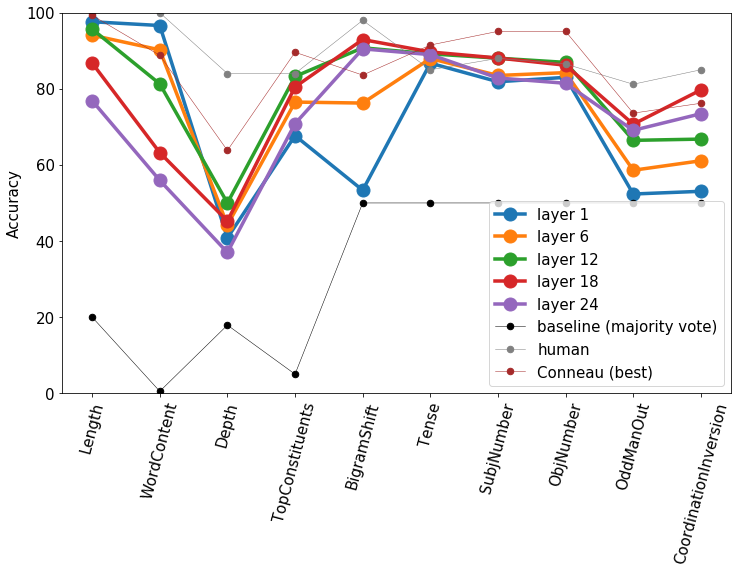

In [4]:
layers = [0, 5, 11, 17, -1]
vals_to_plot = {l: [] for l in layers}
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
group = "teacher_pretrained_avg"
for layer in layers:
    data = pd.read_csv("probing/{}_{}.csv".format(group, layer))
    for task_name in task_names:
        rows = data[data["task"] == task_name]
        best_row = rows.loc[rows["devacc"].idxmax()]
        vals_to_plot[layer].append(best_row["acc"])
        label = "layer {}".format(layer + 1 if layer >= 0 else 24)
    plt.plot(vals_to_plot[layer], label=label, lw=3.5, markersize=13, marker="o")
plt.plot(baselines["majority"], label="baseline (majority vote)", lw=0.5, markersize=13, marker=".", color="black")
plt.plot(baselines["human"], label="human", lw=0.5, markersize=13, marker=".", color="grey")
plt.plot(baselines["conneau-best"], label="Conneau (best)", lw=0.5, markersize=13, marker=".", color="brown")
ax.legend()
ax.set_xticks(np.arange(T))
ax.set_xticklabels(task_names)
plt.xticks(rotation=75)
ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0, top=100)
plt.show()
fig.tight_layout()
fig.savefig("img/probing_layers_{}.png".format(group))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

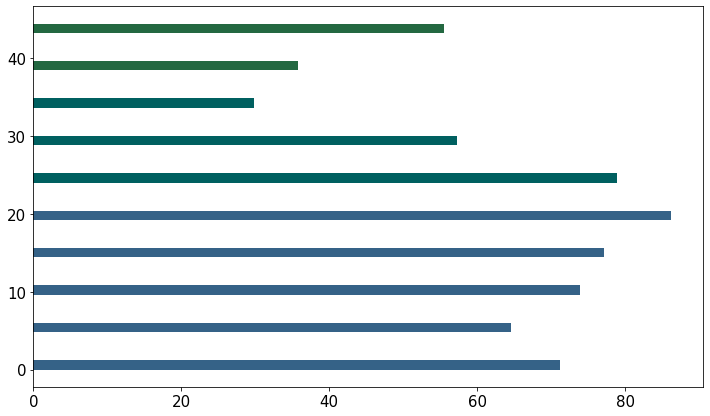

In [6]:
task = "Sara"
layer = -1
vals_to_plot = {strategy: [] for strategy in strategies}
group = "teacher_{}_L{}".format(task, layer)

for strategy in ["single", "avg"]: #strategies:
    data = pd.read_csv("probing/teacher_{}_{}_{}.csv".format(task, strategy, layer))
    for task_name in task_names:
        rows = data[data["task"] == task_name]
        best_row = rows.loc[rows["devacc"].idxmax()]
        vals_to_plot[strategy].append(best_row["acc"])
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()
w = 1.2
for i, strategy in enumerate(strategies):
    ys = np.arange(0, T*4*w, w*4) + i*w
    colour_modifier = 1 + (i - 1)/4
    colours = [modify_cl(task_type_colours[task_type_codes[get_task_type(task)]], colour_modifier) for task in task_names]
    ax.barh(ys, vals_to_plot[strategy][::-1], height=w, align="edge", label=strategy, color=colours[::-1])
ax.set_yticks(np.arange(0, T*4*w, w*4) + 3*w/2)
ax.set_yticklabels(task_names[::-1])
ax.set_xlabel("Accuracy")
ax.set_xlim(left=0, right=100)
plt.legend()
leg = ax.get_legend()
cl = colour_to_bw(np.mean(task_type_colours, axis=0))
for i, (lh, s) in enumerate(zip(leg.legendHandles, strategies)):
    colour_modifier = 1 + (i - 1)/4.7
    lh.set_color(cl*colour_modifier)
fig.tight_layout()
plt.show()
fig.savefig("img/probing_{}.png".format(group))